# <span style="color:#00BDFF">------------- calibration transfer with preprocessing ----------------------</span>

In [1]:
# --------------------------------------------------------------------------

# ----------------- caltransfer protocol with transfer samples

# -------------------------------------------------------------------------


# ¡¡¡ --- !!! # ---> modules and data cases

# --- system modules

import sys
import datetime
import os


# --- data handling modules

import numpy as np
import pandas as pd

# --- pls model building

from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression




# --- visualization modules

import matplotlib.pyplot as plt
import pandas as pd

# --- my modules

methods_dir = '../modules/'  
sys.path.insert(0, methods_dir)
import calibration_transfer as caltransfer
from preprocessing import preprocessing

# <span style="color:#00BDFF">---------------------- 0. all inputs -------------------------</span>

In [2]:

data_url = "https://gitlab.com/vfonsecad/chemometrics_data/-/raw/main/data/nir_pears/pears_all.csv"
data_pd = pd.read_csv(data_url, sep = ";", index_col = 0)
print(data_pd)
print(data_pd.columns)

    instrument sample_id    brix         1         2         3         4  \
0      Instr_1      Cal1  12.600  0.196188  0.158981  0.173367  0.166262   
1      Instr_1      Cal2  11.750  0.288117  0.253641  0.285176  0.259709   
2      Instr_1      Cal3  14.450  0.264574  0.207524  0.248744  0.203883   
3      Instr_1      Cal4  10.900  0.182735  0.131068  0.169598  0.161408   
4      Instr_1      Cal5  12.200  0.260090  0.239078  0.263819  0.222087   
..         ...       ...     ...       ...       ...       ...       ...   
988    Instr_7    Val989  11.500  0.377423  0.378498  0.376754  0.350287   
989    Instr_7    Val990  13.400  0.427746  0.405453  0.435915  0.409428   
990    Instr_7    Val991  13.200  0.432778  0.396966  0.418983  0.356227   
991    Instr_7    Val992  12.567  0.431101  0.424454  0.379478  0.360228   
992    Instr_7    Val993  12.400  0.320390  0.339347  0.318982  0.277985   

            5         6         7  ...       247       248       249  \
0    0.252392  

In [3]:
# creating type column

data_pd['type'] = data_pd["sample_id"].str[0:3].tolist()
data_pd.columns

Index(['instrument', 'sample_id', 'brix', '1', '2', '3', '4', '5', '6', '7',
       ...
       '248', '249', '250', '251', '252', '253', '254', '255', '256', 'type'],
      dtype='object', length=260)

In [37]:
y_name = 'brix' # name of y variable

primary_name = "Instr_1"
secondary_name = "Instr_2"

n_transfer = 245

wv_range = np.arange(0,250)
drop_cal = [32,  685,  772,  778,  780,  781,  786,  867, 1065] # outliers in cal set identified in a previous analysis
drop_test = [32,77]

# clear for outliers
# variable selection
# preprocessing

# transfer goes well epo= external orthogonalization wrt to instrument difference


In [38]:
# get raw data

x_primary_cal_raw_all = np.array(data_pd[(data_pd["instrument"]==primary_name) & (data_pd["type"]=="Cal")].iloc[:,3:-1])[:,wv_range]
y_primary_cal_all = np.array(data_pd[(data_pd["instrument"]==primary_name) & (data_pd["type"]=="Cal")].loc[:,y_name])


x_primary_cal_raw = np.delete(x_primary_cal_raw_all, obj = drop_cal, axis=0)[:,wv_range]
y_primary_cal = np.delete(y_primary_cal_all, obj = drop_cal, axis=0)


x_secondary_test_raw_all = np.array(data_pd[(data_pd["instrument"]==secondary_name) & (data_pd["type"]=="Val")].iloc[:,3:-1])[:,wv_range]
y_secondary_test_all = np.array(data_pd[(data_pd["instrument"]==secondary_name) & (data_pd["type"]=="Val")].loc[:,y_name])

x_secondary_test_raw = np.delete(x_secondary_test_raw_all, obj = drop_test, axis=0)[:,wv_range]
y_secondary_test = np.delete(y_secondary_test_all, obj = drop_test, axis=0)


# get transfer samples

df_transfer_primary_all = data_pd[(data_pd["instrument"]==primary_name) & (data_pd["type"]=="Std")]
transfer_samples = np.random.choice(df_transfer_primary_all.shape[0],n_transfer, replace = False)
df_transfer_primary = df_transfer_primary_all.iloc[transfer_samples,:]
df_transfer_primary_sorted = df_transfer_primary.sort_values("sample_id")

df_transfer_secondary_all = data_pd[(data_pd["instrument"]==secondary_name) & (data_pd["type"]=="Std")]
df_transfer_secondary = df_transfer_secondary_all[df_transfer_secondary_all["sample_id"].isin(df_transfer_primary_sorted["sample_id"])]
df_transfer_secondary_sorted = df_transfer_secondary.sort_values("sample_id")

print(np.all(df_transfer_primary_sorted["sample_id"].tolist() == df_transfer_secondary_sorted["sample_id"].tolist()))


x_primary_raw = np.array(df_transfer_primary_sorted.iloc[:,3:-1])[:,wv_range]
x_secondary_raw = np.array(df_transfer_secondary_sorted.iloc[:,3:-1])[:,wv_range]

y_primary = None
y_secondary = None




True


In [6]:
# choose preprocessing from here

# dir(preprocessing)


In [39]:
# preprocessing

deriv_w = 11
po = 3
do = 2


mypp = preprocessing(x_primary_cal_raw,y_primary_cal)

x_primary_cal_deriv = mypp.savgol_derivative(window_width = deriv_w, polynomial_order = po, derivative_order = do, xx_test=None)
x_primary_deriv = mypp.savgol_derivative(window_width = deriv_w, polynomial_order = po, derivative_order = do, xx_test=x_primary_raw)
x_secondary_deriv = mypp.savgol_derivative(window_width = deriv_w, polynomial_order = po, derivative_order = do, xx_test=x_secondary_raw)
x_secondary_test_deriv = mypp.savgol_derivative(window_width = deriv_w, polynomial_order = po, derivative_order = do, xx_test=x_secondary_test_raw)


x_primary_cal = x_primary_cal_deriv.copy()
x_primary = x_primary_deriv.copy()
x_secondary = x_secondary_deriv.copy()
x_secondary_test = x_secondary_test_deriv.copy()


In [40]:
# input parameters part 1


total_lv = 30 # total of lv for calibration models

# specify methods for transfer

method_inst = "epo" #ds, pds, epo, none 
model_spec = "none" #jointpls, none 


build_original_model = "yes" # yes, no. To build crossval for original calmodel with cal data. If not, prompted directly for final lv

save_final_model = False

output_model_path = ".."

In [41]:
# input parameters part 2

# extra parameters for instrument/environment transfer

if method_inst == "pds":    
    w_pds = int(input("half window width: "))
    print("total window width: " + str(2*w_pds+1))
    max_pc_ds = int(input("number of LV's for PDS window: "))
    ncomp_epo = None
elif method_inst == "epo":
    ncomp_epo = int(input("number of EPO components: "))
    w_pds = None
    max_pc_ds = None
elif method_inst == "ds":
    max_pc_ds = int(input("number of PC's for DS: "))
    ncomp_epo = None
    w_pds = None
elif method_inst!="none":
    print("method name must be ds, pds, epo or none")
    max_pc_ds = None
    ncomp_epo = None
    w_pds = None
    

    
# full transfer method name identifier

transfer_name = method_inst + "_" +model_spec
    
if build_original_model == "yes":
    build_original_model = True
else:
    build_original_model = False
    
print("done")

number of EPO components:  1


done


# <span style="color:#00BDFF">---------------------- 1. perform calibration transfer -------------------------</span>

In [42]:

def build_plsr_calibration(x_primary_cal, y_primary_cal,chosen_lv):
    
    '''
    output: (B,beta,R,q,x_mean,y_mean)
    
    '''
    
    # plsr using sklearn
   
    my_pls = PLSRegression(n_components = chosen_lv,scale=False)
    my_pls.fit(x_primary_cal, y_primary_cal)
    T_scores = (x_primary_cal-my_pls.x_mean_).dot(my_pls.x_rotations_)
    my_pls_ls = LinearRegression()
    my_pls_ls.fit(T_scores,y_primary_cal) # output values need to be 1D always here

    
    # deliver parameters for plsr
    
    R = my_pls.x_rotations_ #loadings to calculate scores
    q = my_pls_ls.coef_
    x_mean = my_pls.x_mean_
    y_mean = my_pls_ls.intercept_ 
    B = my_pls.coef_ # must be the same as Rq
    beta = y_mean - (x_mean.dot(B))
    
    
    
    return (B, beta,R,q,x_mean,y_mean)


def caltransfer_protocol():
    
    print(transfer_name + "\n")
    
    ##################################################################################################################
    ##################################################################################################################

    #                                1. calibration model

    ##################################################################################################################
    ##################################################################################################################

    # --- input
    
    
    
    print("\n ********** BUILDING ORIGINAL CALIBRATION MODEL ********** \n")


    print("x cal size: ", x_primary_cal.shape)


    # --- process
    
    if build_original_model:


        n_splits_cv = 5
        n_shuffles = 3

        parameters = {'n_components': list(range(1,total_lv+1))}
        pls_scoring = {'r2': 'r2', 'rmse': 'neg_root_mean_squared_error'}


        fig, axs = plt.subplots(1,2,figsize = (20,8))

        for nn in range(n_shuffles):

            pls_cv = KFold(n_splits=n_splits_cv, shuffle=True)
            my_pls = PLSRegression(scale=False)
            my_pls_cv = GridSearchCV(my_pls, parameters, cv = pls_cv, scoring = pls_scoring, refit = False)
            my_pls_cv.fit(x_primary_cal, y_primary_cal)

            axs[0].plot(my_pls_cv.cv_results_["param_n_components"],-1*my_pls_cv.cv_results_["mean_test_rmse"], c = "blue")
            axs[1].plot(my_pls_cv.cv_results_["param_n_components"],my_pls_cv.cv_results_["mean_test_r2"], c = "blue")

        axs[0].set_xlabel("lv")
        axs[0].set_ylabel("rmsecv")
        axs[0].grid()

        axs[1].set_xlabel("lv")
        axs[1].set_ylabel("r2")
        axs[1].set_ylim([0,1])
        axs[1].grid()


        fig.suptitle("cv with {} splits and {} shuffles".format(n_splits_cv, n_shuffles))
        plt.show()

    chosen_lv = int(input("choose number of lv: "))

    
    calmodel = build_plsr_calibration(x_primary_cal, y_primary_cal,chosen_lv)
    
    (B_original, beta_original,R_original,q_original,x_mean_original,y_mean_original) = calmodel

    print("original calibration model done")

    ##################################################################################################################
    ##################################################################################################################

    #                                2. calibration transfer model: fit and apply

    ##################################################################################################################
    ##################################################################################################################

    print("\n ********** CALIBRATION TRANSFER (INSTRUMENT VARIATION) ********** \n")
    
    # --- input

    print("x primary size: ", x_primary.shape,"x secondary size: ",x_secondary.shape)
    print("x test size: ", x_secondary_test.shape)



    # --- process
    
    if transfer_name == "none_jointpls" or transfer_name=="none_none":
        
        x_primary_tr = x_primary.copy()
        x_secondary_tr = x_secondary.copy()
        x_primary_cal_tr = x_primary_cal.copy()
        x_secondary_test_tr = x_secondary_test.copy()
        
        (B_inst, beta_inst,R_inst,q_inst,x_mean_inst,y_mean_inst,F,b) = (B_original, beta_original,R_original,
                                                                         q_original,x_mean_original,y_mean_original,
                                                                         np.identity(R_original.shape[0]),np.zeros(x_mean_original.shape))

  
    else:  


        # ds or pds

        if "ds" in transfer_name and "pds" not in transfer_name:

            # fit

            max_ncp = np.amin([max_pc_ds,np.amin(x_primary.shape)-1])
            F,b = caltransfer.ds_pc_transfer_fit(x_primary, x_secondary, max_ncp)
            x_primary_tr = x_primary.copy()
            x_secondary_tr = x_secondary.dot(F) + b

            # apply

            x_primary_cal_tr = x_primary_cal.copy()
            x_secondary_test_tr = x_secondary_test.dot(F) + b
            
            # transferred parms
            
            B_inst = F.dot(B_original)
            beta_inst = b.dot(B_original) + beta_original
            beta_inst.shape = beta_original.shape
            R_inst = R_original.copy()
            q_inst = q_original.copy()
            x_mean_inst = x_mean_original.copy()
            y_mean_inst = y_mean_original.copy()
            
  
        


        elif "pds" in transfer_name:

            # fit

            max_ncp = np.amin([max_pc_ds,np.amin(x_primary.shape)-1])
            F,b = caltransfer.pds_pls_transfer_fit(x_primary, x_secondary, max_ncp, ww = w_pds)
            x_primary_tr = x_primary.copy()
            x_secondary_tr = x_secondary.dot(F) + b

            # apply

            x_primary_cal_tr = x_primary_cal.copy()
            x_secondary_test_tr = x_secondary_test.dot(F) + b
            
            # transferred parms
            
            B_inst = F.dot(B_original)
            beta_inst = b.dot(B_original) + beta_original
            beta_inst.shape = beta_original.shape
            R_inst = R_original.copy()
            q_inst = q_original.copy()
            x_mean_inst = x_mean_original.copy()
            y_mean_inst = y_mean_original.copy()



        elif "epo" in transfer_name:

            # fit


            my_pp = preprocessing(x_primary)
            F,b = my_pp.epo_fit(x_secondary,current_epo_ncp = ncomp_epo)            

            x_primary_tr = x_primary.dot(F) + b # here primary also changes
            x_secondary_tr = x_secondary.dot(F) + b

            # apply

            x_primary_cal_tr = x_primary_cal.dot(F) + b
            x_secondary_test_tr = x_secondary_test.dot(F) + b
            
            # transferred parms in next section
            


        # --- output
        
        x_primary_tr
        x_secondary_tr
        x_primary_cal_tr
        x_secondary_test_tr
        F
        b

        print("--- ", transfer_name, " ---")

        # spectra

        
        plt.plot(x_primary_tr.T, c = "blue")
        plt.plot(x_primary_tr[0,:], c = "blue", label = primary_name)
        plt.plot(x_secondary_tr.T, c = "red")
        plt.plot(x_secondary_tr[0,:], c = "red", label = secondary_name)
        plt.grid()
        plt.title("transfer samples")
        plt.legend()
        plt.show()

        # spectra


        plt.plot(x_primary_cal_tr.T, c = "blue")
        plt.plot(x_secondary_test_tr.T, c = "red")
        plt.grid()
        plt.title(primary_name + " (cal) - " + secondary_name + " (test)")
        plt.show()


    ##################################################################################################################
    ##################################################################################################################

    #                                2.1 recalibration with xcal_tr

    ##################################################################################################################
    ##################################################################################################################
    
    
    # --- input

    x_primary_cal_tr
    y_primary_cal
    x_secondary_tr # for testing
    y_secondary # for testing
    
    
    if "epo" in transfer_name:
    
        print("\n ********** RECALIBRATING ORIGINAL MODEL ********** \n")
        
        n_splits_cv = 5
        n_shuffles = 2

        parameters = {'n_components': list(range(1,total_lv+1))}
        pls_scoring = {'r2': 'r2', 'rmse': 'neg_root_mean_squared_error'}


        fig, axs = plt.subplots(1,2,figsize = (20,8))

        for nn in range(n_shuffles):

            pls_cv = KFold(n_splits=n_splits_cv, shuffle=True)
            my_pls = PLSRegression(scale=False)
            my_pls_cv = GridSearchCV(my_pls, parameters, cv = pls_cv, scoring = pls_scoring, refit = False)
            my_pls_cv.fit(x_primary_cal_tr, y_primary_cal)

            axs[0].plot(my_pls_cv.cv_results_["param_n_components"],-1*my_pls_cv.cv_results_["mean_test_rmse"], c = "blue", label = "cv iter {}".format(nn) )
            axs[1].plot(my_pls_cv.cv_results_["param_n_components"],my_pls_cv.cv_results_["mean_test_r2"], c = "blue",label = "cv iter {}".format(nn))


        
            # model on test for all lv
            
        if y_secondary is not None:

            rmsep = np.zeros(total_lv)
            r2p = np.zeros(total_lv)


            my_pls_total = PLSRegression(n_components = total_lv,scale=False)
            my_pls_total.fit(x_primary_cal_tr, y_primary_cal)
            T_scores = (x_primary_cal_tr-x_primary_cal_tr.mean(axis=0)).dot(my_pls_total.x_rotations_)

            for chosen_lv in range(1, total_lv+1):

                my_pls_total_ls = LinearRegression()
                my_pls_total_ls.fit(T_scores[:,0:chosen_lv],y_primary_cal) # output values need to be 1D always here

                B = my_pls_total.x_rotations_[:,0:chosen_lv].dot(my_pls_total_ls.coef_[0:chosen_lv])
                beta = my_pls_total.y_mean_ - (my_pls_total.x_mean_.dot(B))

                y_secondary_pred = x_secondary_tr.dot(B) + beta
                rmsep[chosen_lv-1] = np.sqrt(mean_squared_error(y_secondary, y_secondary_pred))
                r2p[chosen_lv-1] = r2_score(y_secondary, y_secondary_pred)


            axs[0].plot(my_pls_cv.cv_results_["param_n_components"],rmsep, c = "orange", label = "test")
            axs[1].plot(my_pls_cv.cv_results_["param_n_components"],r2p, c = "orange", label = "test")
            
        axs[0].set_xlabel("lv")
        axs[0].set_ylabel("rmsecv")
        axs[0].grid()
        axs[0].legend()

        axs[1].set_xlabel("lv")
        axs[1].set_ylabel("r2")
        axs[1].set_ylim([0,1])
        axs[1].grid()        
        axs[1].legend()


        fig.suptitle("cv with {} splits and {} shuffles".format(n_splits_cv, n_shuffles))
        plt.show()

        chosen_lv = int(input("choose number of lv: "))

        calmodel_epo = build_plsr_calibration(x_primary_cal_tr, y_primary_cal,chosen_lv)
    
        (B_epo, beta_epo,R_epo,q_epo,x_mean_epo,y_mean_epo) = calmodel_epo
        
        # transferred parms

        B_inst = F.dot(B_epo)
        beta_inst = b.dot(B_epo) + beta_epo
        R_inst = R_epo.copy()
        q_inst = q_epo.copy()
        x_mean_inst = x_mean_epo.copy()
        y_mean_inst = y_mean_epo.copy()  
        
        

        print("recalibration done")

    
    ##################################################################################################################
    ##################################################################################################################

    #                                3. joint pls

    ##################################################################################################################
    ##################################################################################################################
    
    
    # --- input

    x_primary_tr
    x_secondary_tr
    y_primary
    y_secondary
    R_inst
    x_mean_inst
    
    if "jointpls" not in transfer_name:
        
        B_mod = B_inst.copy()
        beta_mod = beta_inst.copy()
        R_mod = R_inst.copy()
        q_mod = q_inst.copy()
        x_mean_mod = x_mean_inst.copy()
        y_mean_mod = y_mean_inst.copy()
        
        diff_model_specification = False
        
        
        
    else:
  
        print("\n ********** CALIBRATION TRANSFER (MODEL SPECIFICATION) ********** \n")


        tscores_primary = (x_primary_tr - x_mean_inst).dot(R_inst)
        tscores_secondary = (x_secondary_tr - x_mean_inst).dot(R_inst)

        t_jointpls = np.concatenate((tscores_primary,tscores_secondary), axis = 0)
        y_jointpls = np.concatenate((y_primary,y_secondary), axis = 0)


        calmodel_tr_jointpls = LinearRegression()
        calmodel_tr_jointpls.fit(t_jointpls,y_jointpls) # output values need to be 1D always here

        diff_model_specification = True
        
  
        # output
  
        q_mod = calmodel_tr_jointpls.coef_  
        B_mod = F.dot(R_inst).dot(q_mod) # see here how the B coefficient is finally specified
        beta_mod = np.asarray(calmodel_tr_jointpls.intercept_ + (b - x_mean_inst).dot(R_inst.dot(q_mod))) # see here how the beta coefficient is finally specified
        beta_mod.shape = beta_inst.shape
        y_mean_mod = calmodel_tr_jointpls.intercept_
        R_mod = R_inst.copy()
        x_mean_mod = x_mean_inst.copy()
        


    # --- output

    # calmodel_tr_jointpls


    ##################################################################################################################
    ##################################################################################################################

    #                                4. deliver final model

    ##################################################################################################################
    ##################################################################################################################
    
    print("\n ********** DELIVERING FINAL MODEL ********** \n")

    # --- process
    
    
    calmodel_to_export = {"B":B_mod, "intercept": beta_mod}

    print("--- " , transfer_name, " ---\n")
    
    
    plt.plot(B_original, c = "#0056a6", label = "original")
    plt.plot(B_inst, c = "#ffc900", label =  "only instrument transfer", linewidth=4)
    plt.plot(B_mod, c = "#c82714", label = "model specif transfer")
    plt.grid()
    plt.legend()
    plt.title("transfer of regression vector")
    plt.show()
    
    print("original beta intercept: ", beta_original)
    print("only instrument transfer beta intercept: ", beta_inst)
    print("model specif beta intercept: ", beta_mod)

    if diff_model_specification:        

        plt.scatter(q_inst,q_mod, c = "#7400b2")
        plt.plot([np.amin(q_mod), np.amax(q_mod)],[np.amin(q_mod), np.amax(q_mod)], c = "gray")
        plt.xlabel("q coeff before model specif", color = "#ffc900")
        plt.ylabel("q coeff after model specif", color = "#c82714")
        plt.title("scores slopes difference due to model specification")
        plt.grid()
        plt.show()

    




    # --- output

    # calmodel_to_export = {"B":B, "intercept": beta}
    
    return calmodel_to_export


epo_none


 ********** BUILDING ORIGINAL CALIBRATION MODEL ********** 

x cal size:  (1057, 250)


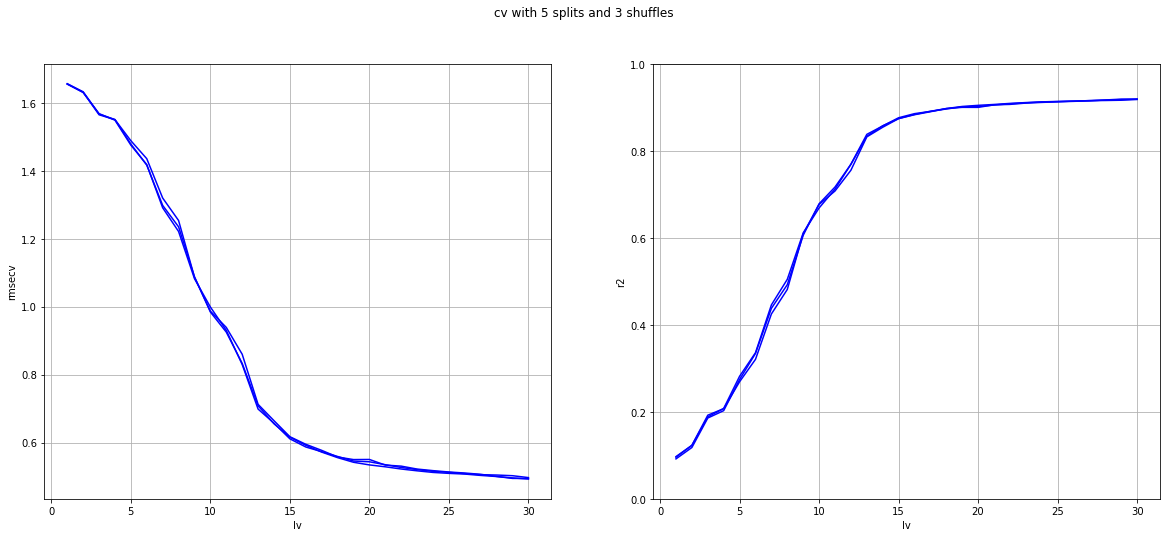

choose number of lv:  15


original calibration model done

 ********** CALIBRATION TRANSFER (INSTRUMENT VARIATION) ********** 

x primary size:  (245, 250) x secondary size:  (245, 250)
x test size:  (176, 250)
---  epo_none  ---


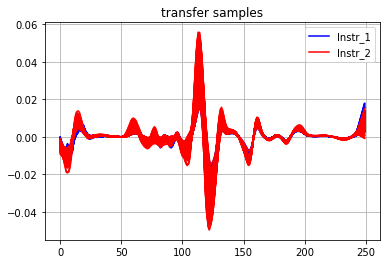

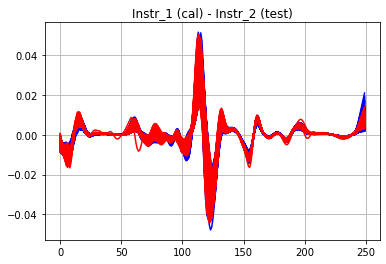


 ********** RECALIBRATING ORIGINAL MODEL ********** 



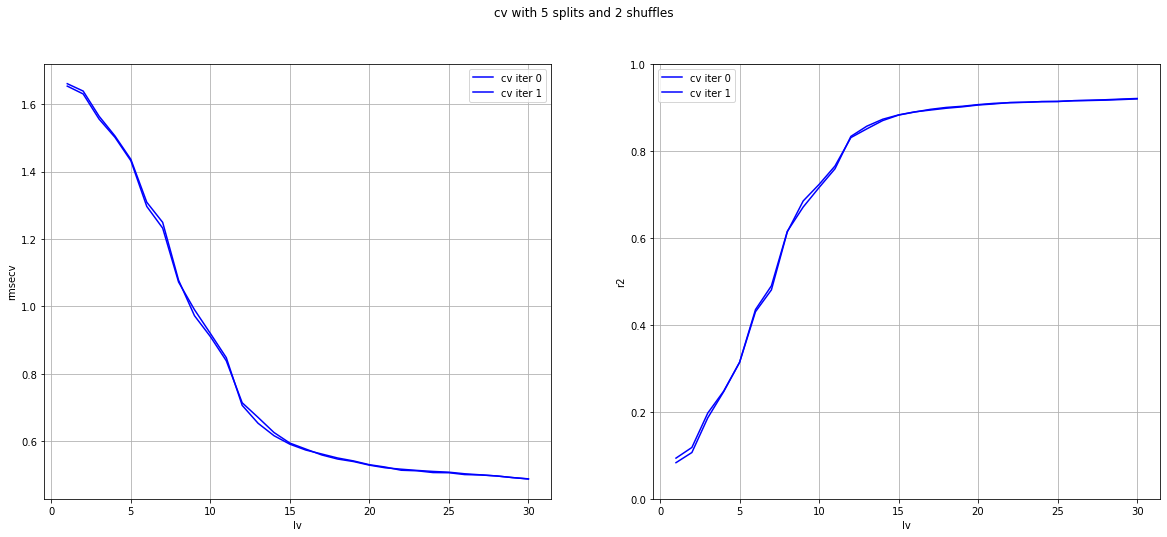

choose number of lv:  15


recalibration done

 ********** DELIVERING FINAL MODEL ********** 

---  epo_none  ---



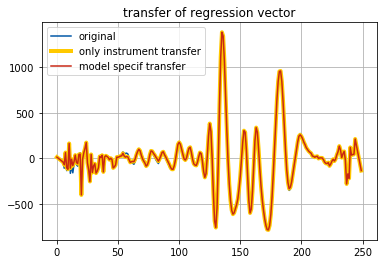

original beta intercept:  [12.84963658]
only instrument transfer beta intercept:  [12.84666582]
model specif beta intercept:  [12.84666582]


In [43]:
calmodel_to_export = caltransfer_protocol()

# <span style="color:#00BDFF">---------------------- 2. use final cal model -------------------------</span>

In [44]:
# deliver a function for prediction on new data, if not jointpls, define your own function

if save_final_model:
    
    sp_io.savemat(output_model_path +  "/calmodel_for_" + secondary_name + ".mat", calmodel_to_export)


def final_calmodel_predict(xnew_raw, B, beta):
    
    ynew_pred = xnew_raw.dot(B) + beta
    ynew_pred.shape = (ynew_pred.shape[0],1)
    
    return ynew_pred


## input

In [45]:
final_calmodel_predict
B = calmodel_to_export["B"]
beta = calmodel_to_export["intercept"]


newdata_dict = { secondary_name + " (test)": {"x": x_secondary_test,"y":y_secondary_test},
                    primary_name + " (cal)":  {"x": x_primary_cal,"y":y_primary_cal}} # possibility to input different sets of data

newdata_dict.keys()

dict_keys(['Instr_2 (test)', 'Instr_1 (cal)'])

## process

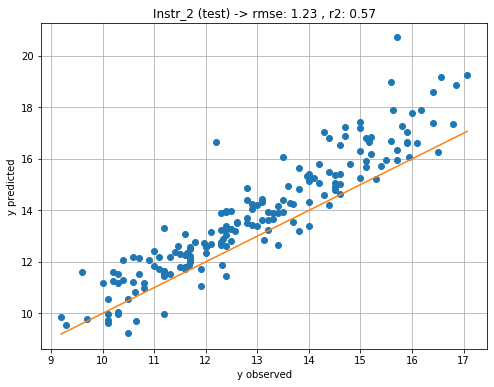

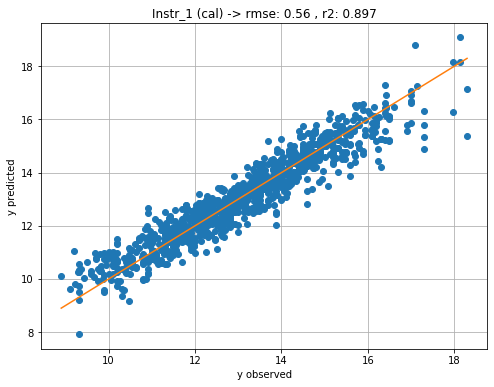

In [46]:
for dataset in newdata_dict.keys():
    
    xnew_raw = newdata_dict[dataset]["x"].copy()
    ynew_pred = final_calmodel_predict(xnew_raw, B, beta)
    newdata_dict[dataset]["ypred"] = ynew_pred.copy()
    
    if "y" in newdata_dict[dataset].keys():
        
        ynew = newdata_dict[dataset]["y"].copy() 
        rmsep = np.sqrt(mean_squared_error(ynew, ynew_pred))
        r2p = r2_score(ynew, ynew_pred)

        performance_str = "rmse: "+ str(np.round(rmsep,3))+ " , r2: " +str(np.round(r2p,3))

        plt.subplots(figsize = (8,6))
        plt.plot(ynew,ynew_pred,'o')
        plt.plot([np.amin(ynew), np.amax(ynew)],[np.amin(ynew), np.amax(ynew)])
        plt.grid()
        plt.xlabel("y observed")
        plt.ylabel("y predicted")
        plt.title(dataset + " -> " + performance_str)
        plt.show()

        #print("rmse: ", rmsep, "r2: ",r2p,"\n --- \n")
    


## output

In [25]:
for ds in newdata_dict.keys():
    print(ds," - ", newdata_dict[ds].keys())

new  -  dict_keys(['x', 'y', 'ypred'])
cal_all  -  dict_keys(['x', 'y', 'ypred'])
